# Handwriting classifier using a convolutional neural network

Trained on EMNIST dataset. See ReadMe for EMNIST dataset download

Code block below is loading in dataset and splitting into appropriate sections

In [1]:
# import libraries
import os
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.utils.data import DataLoader, TensorDataset
import gzip
import copy
import string


# for importing data
import torchvision
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')





/tmp/ipykernel_50478/2150169011.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
#directory path
dataset_dir = 'data/gzip'

train_images_path = os.path.join(dataset_dir, 'emnist-letters-train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(dataset_dir, 'emnist-letters-train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(dataset_dir, 'emnist-letters-test-images-idx3-ubyte.gz')
test_labels_path = os.path.join(dataset_dir, 'emnist-letters-test-labels-idx1-ubyte.gz')

# loading from binary into numpy arrays
train_images = np.fromfile(train_images_path, dtype=np.uint8)
train_labels = np.fromfile(train_labels_path, dtype=np.uint8)
test_images = np.fromfile(test_images_path, dtype=np.uint8)
test_labels = np.fromfile(test_labels_path, dtype=np.uint8)

In [3]:
# using gzip to properly extract from zip file

with gzip.open(train_images_path, 'rb') as f:
    train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16)

with gzip.open(train_labels_path, 'rb') as f:
    train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

with gzip.open(test_images_path, 'rb') as f:
    test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16)

with gzip.open(test_labels_path, 'rb') as f:
    test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)


In [42]:
print(train_images.shape)
print(train_labels.shape)

(124800, 28, 28)
(124800,)


In [48]:
# reshaping into 28 by 28 matrixes
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)

# seeing number of classes. Should be 26 for both
print(np.unique(train_labels))
print(np.unique(test_labels))

print(train_images.shape)
print(test_images.shape)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0  20 114 125  82  37  37  39 115 157  94  21  10  32  37  37  37
   37  37  37  37  82 125 114  20   0   0]
 [  0   3 109 245 249 233 217 217 217 245 251 234 172 142 203 217 217 217
  217 217 217 217 233 249 245 109   3   0]
 [  0   4 114 253 254 254 254 254 254 254 254 254 252 251 254 254 254 254
  254 254 254 254 254 254 254 127   4   0]
 [  0   0  45 214 233 251 254 254 254 254 255 255 255 255 255 255 255 255
  255 255 255 255 254 254 251 113   4   0]
 [  0   0   0   5  

In [6]:
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)

# Check the number of channels in the images
print("Number of Channels in Train Images:", train_images.shape[1])
print("Number of Channels in Test Images:", test_images.shape[1])


Train Images Shape: (124800, 28, 28)
Test Images Shape: (20800, 28, 28)
Number of Channels in Train Images: 28
Number of Channels in Test Images: 28


Using matplot lib to show representation of our data. 
Extra step to make sure it is being loaded in correctly. 

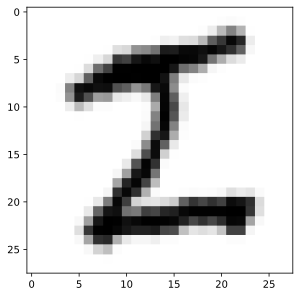

In [7]:
plt.imshow(test_images[9871], cmap = plt.cm.binary)
plt.show()

### Converting NumPy Arrays into PyTorch Tensors for later use
Will also be normalizing the tensors for a value between 0 and 1 for better performance


In [8]:
train_tensor_images = torch.from_numpy(train_images)
test_tensor_images = torch.from_numpy(test_images)


train_tensor_images = train_tensor_images.unsqueeze(1)
test_tensor_images = test_tensor_images.unsqueeze(1)

train_tensor_images = torch.transpose(train_tensor_images, 2, 3)
test_tensor_images = torch.transpose(test_tensor_images, 2, 3)

train_tensor_images.shape

/tmp/ipykernel_50478/2971545.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  train_tensor_images = torch.from_numpy(train_images)


torch.Size([124800, 1, 28, 28])

In [9]:
#convert to tensors & change data type to float
train_images_tensor = train_tensor_images.float()
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_images_tensor = test_tensor_images.float()
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_images_normalized = F.normalize(train_images_tensor, dim = 1)
test_images_normalized = F.normalize(test_images_tensor, dim = 1)




In [10]:
print("Train Images Tensor Shape:", train_images_tensor.shape)
print("Test Images Tensor Shape:", test_images_tensor.shape)

# Check the number of channels in the images tensors
print("Number of Channels in Train Images Tensor:", train_images_tensor.shape[1])
print("Number of Channels in Test Images Tensor:", test_images_tensor.shape[1])


Train Images Tensor Shape: torch.Size([124800, 1, 28, 28])
Test Images Tensor Shape: torch.Size([20800, 1, 28, 28])
Number of Channels in Train Images Tensor: 1
Number of Channels in Test Images Tensor: 1


Plot to show letters with their corresponding labels. Current problem of labels showing up as numerical index of letter in alphabet instead of actual letter label. Potentially find a way to have correct orientation on images as well?

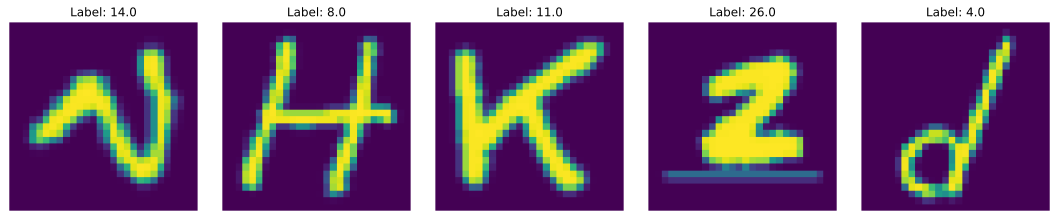

In [37]:
import matplotlib.pyplot as plt
import random
# Number of images to visualize
num_images = 5

# Randomly select indices for the images
random_indices = random.sample(range(len(test_images_tensor)), num_images)

# Plot the images and their corresponding labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    # Get the image and label at the selected index
    image = test_images_tensor[idx]
    label = test_labels_tensor[idx]
    
    if image.dim() == 3:  # Check if image has three dimensions (channels)
        axes[i].imshow(image.permute(1, 2, 0).numpy())
    else:
        axes[i].imshow(image.numpy(), cmap='gray')  # Assuming images are grayscale
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Next step is process them into PyTorch Datasets to later make them into Dataloaders for the actual training and testing

check each transformationfor how many channels we have going on

In [12]:
#convert to PyTorch Data Set. Check for number of channels
train_data = TensorDataset(train_images_normalized, train_labels_tensor)
test_data = TensorDataset(test_images_normalized, test_labels_tensor)


In [13]:

print("Train Data Length:", len(train_data))
print("Test Data Length:", len(test_data))

# Check the shape of the first image in train and test datasets
print("Shape of the First Image in Train Data:", train_data[0][0].shape)
print("Shape of the First Image in Test Data:", test_data[0][0].shape)

# Check the number of channels in the first image in train and test datasets
print("Number of Channels in the First Image in Train Data:", train_data[0][0].shape[0])
print("Number of Channels in the First Image in Test Data:", test_data[0][0].shape[0])


Train Data Length: 124800
Test Data Length: 20800
Shape of the First Image in Train Data: torch.Size([1, 28, 28])
Shape of the First Image in Test Data: torch.Size([1, 28, 28])
Number of Channels in the First Image in Train Data: 1
Number of Channels in the First Image in Test Data: 1


In [14]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [15]:
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)

torch.Size([124800, 1, 28, 28])
torch.Size([20800, 1, 28, 28])


In [16]:
min_pixel_value = torch.min(train_loader.dataset.tensors[0])
max_pixel_value = torch.max(train_loader.dataset.tensors[0])

if min_pixel_value == max_pixel_value:
    print("All pixel values are the same, indicating grayscale images.")
    num_channels = 1
else:
    print("Pixel values vary, indicating images may contain multiple channels.")
    num_channels = train_loader.dataset.tensors[0].shape[1]

print("Number of channels in the images:", num_channels)

Pixel values vary, indicating images may contain multiple channels.
Number of channels in the images: 1


## Data Preprocessing is done. Can make model architecture now
Convolutional Neural network will be model used

Channel Problem fixed. All of my images are swapped. The height is being read in as the width and they are all showing up as horizontal images

Another problem is the abnormally high test error rate


In [17]:
def makeTheNet(printtoggle = False):

    class CNN(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()


            #print toggle
            self.print = printtoggle

            #first convolutional layer
            # in channel, out channel, kernel size, padding
            self.conv1 = nn.Conv2d(1,6,kernel_size=3,padding=1)
            # batch normalization
            self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels on this layer

            #second convolutional layer
            self.conv2 = nn.Conv2d(6,6,kernel_size=3,padding=1,stride=1)
            self.bnorm2 = nn.BatchNorm2d(6)


            #linear decision layers
            """compute the output size for the convolutional layers
                then make it the input size for the linear layers"""
            self.fc1 = nn.Linear(7*7*6,50) 
            self.fc2 = nn.Linear(50,27)
    
        def forward(self, x):
            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f'First CPR block: {list(x.shape)}')

            # second block 
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f'Second CPR block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            #linear layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    # model instance
    net = CNN(printtoggle)

    # loss function
    loss_fun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)

    return net,loss_fun,optimizer

In [18]:
net,loss_fun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)
y = y.type(torch.LongTensor)

#check the size of the output
print("\nOutputSize:")
print(yHat.shape)

# compute loss 
loss = loss_fun(yHat, torch.squeeze(y))
print(' ')
print('Loss: ')
print(loss)


Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vectorized: [32, 294]
Final output: [32, 27]

OutputSize:
torch.Size([32, 27])
 
Loss: 
tensor(3.2915, grad_fn=<NllLossBackward0>)


In [19]:
def trainModel():
    numepochs = 10

    net,loss_fun, optimizer = makeTheNet()

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    testErr = torch.zeros(numepochs)

    for epochi in range(numepochs):
        net.train()
        batchLoss = []
        batchErr = []
        testBatchLoss = []
        testBatchErr = []
        
        for X, y in train_loader:
            
            #forward pass and loss
            yHat = net(X)
            y = y.type(torch.LongTensor)
            loss = loss_fun(yHat,y)

            #backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss and error from this batch
            batchLoss.append(loss.item())
            batchErr.append(torch.mean((torch.argmax(yHat,axis=1)!=y).float()).item())
        #end of batch loop

        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = 100*np.mean(batchErr)

        # tests performance
        net.eval()
        # X,y = next(iter(test_loader))

        


        with torch.no_grad():
            for X, y in test_loader:

                yHat= net(X)
                y =  y.type(torch.LongTensor)
                loss = loss_fun(yHat, y)

                testBatchLoss.append(loss.item())
                testBatchErr.append(torch.mean((torch.argmax(yHat,axis=1)!=y).float()).item())

            
            testLoss[epochi] = np.mean(testBatchLoss)
            testErr[epochi] = 100*np.mean(testBatchErr)
    return trainLoss, testLoss, trainErr, testErr, net

# Visualization and model evaluation

Model is performing well but the loss functions are not graphing or not being calculated correctly

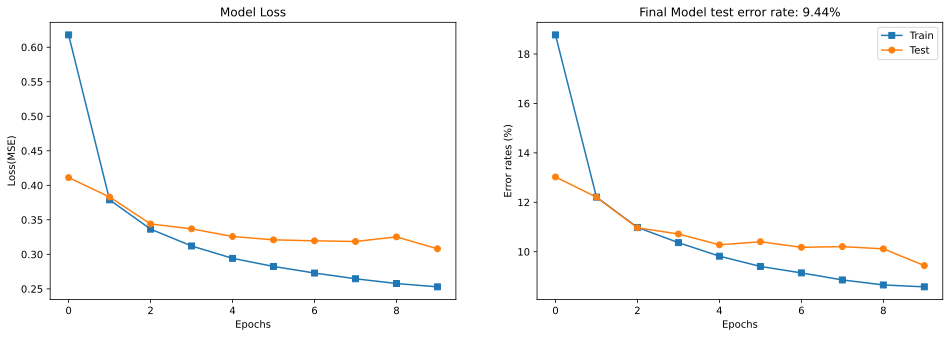

In [20]:
trainLoss, testLoss, trainErr, testErr, net = trainModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss(MSE)')
ax[0].set_title('Model Loss')


ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final Model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()


In [27]:
torch.save(net.state_dict(), 'CNN.pth')

In [21]:
def display_random_images(model, data_loader, num_images=10):
    # Set the model to evaluation mode
    model.eval()

    # Get random indices
    randex = np.random.choice(len(data_loader.dataset), size=num_images, replace=False)

    alphabet = list(string.ascii_lowercase)

    # Iterate over the random indices
    for i, index in enumerate(randex):
        # Get the image and label from the dataset
        image, label = data_loader.dataset[index]

        # Make prediction
        with torch.no_grad():
            output = model(image.unsqueeze(0))  # Add batch dimension

        # Get predicted label
        _, predicted = torch.max(output, 1)
        predicted = predicted.item()  # Convert to scalar

        # Change color if prediction is incorrect
        if predicted != label:
            plt.subplot(2, 5, i + 1)
            plt.imshow(image.squeeze(), cmap='Oranges')  # Change color to 'hot' for incorrect prediction
            plt.title(f'True: {alphabet[int(label)-1]}, Predicted: {alphabet[int(predicted)-1]}', color = 'red', fontsize = 6)
            plt.axis('off')
        else:
            plt.subplot(2, 5, i + 1)
            plt.imshow(image.squeeze(), cmap='gray')  # Default color for correct prediction
            plt.title(f'True: {alphabet[int(label)-1]}, Predicted: {alphabet[int(predicted)-1]}', fontsize = 6)
            plt.axis('off')

    plt.show()


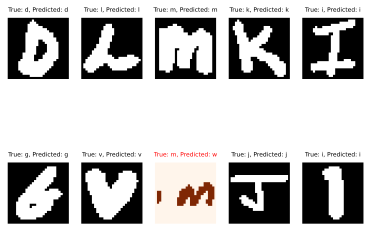

In [28]:
display_random_images(net, test_loader, num_images=10)

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm


def plot_confusion_matrix(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the data loader to get true and predicted labels
    for images, labels in data_loader:
        # Make predictions
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    alphabet = list(string.ascii_lowercase)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linecolor='gray', linewidths=1, norm=LogNorm(), annot_kws={"ha": 'center',"va": 'center','fontsize': 8})
    plt.xlabel('Predicted Letter')
    plt.ylabel('True Letter')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(alphabet))+0.5, alphabet)  # Set x-axis labels to alphabet letters
    plt.yticks(np.arange(len(alphabet))+0.5, alphabet)
    plt.show()

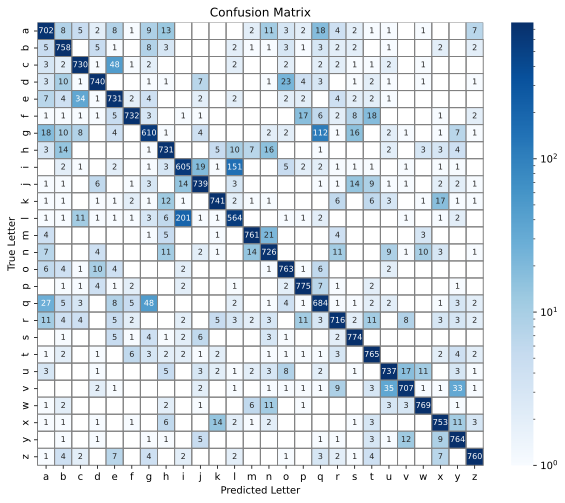

In [24]:
plot_confusion_matrix(net, test_loader)